# Exploring model variants with `screen`

This notebooks demonstrates a simple use of `screen` to explore large
number of model variants. On the toy *E. Coli* model, we try to map the
impact of knocking out single reactions and 2-reaction combinations.

First, let's download the data and load the packages and the model

In [1]:
!isfile("e_coli_core.json") &&
    download("http://bigg.ucsd.edu/static/models/e_coli_core.json", "e_coli_core.json");

using COBREXA, Tulip

model = load_model(StandardModel, "e_coli_core.json")

Metabolic model of type StandardModel
sparse([9, 51, 55, 64, 65, 34, 44, 59, 66, 64  …  20, 22, 23, 25, 16, 17, 34, 44, 57, 59], [1, 1, 1, 1, 1, 2, 2, 2, 2, 3  …  93, 93, 94, 94, 95, 95, 95, 95, 95, 95], [1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0  …  1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 72, 95)
Number of reactions: 95
Number of metabolites: 72


## Preparing the functions

While we could use the `with_changed_bound` to limit the reaction rates,
but we will make a slightly more precise, usage-tailored modification. This
is a straightforward modification of the `with_changed_bound` that does
not set bounds "outside" of the original bounds:

In [2]:
with_limited_rate(reaction_id::String, limit) =
    model::StandardModel -> begin
        m = copy(model)
        m.reactions = copy(model.reactions)
        r = m.reactions[reaction_id] = copy(model.reactions[reaction_id])
        if -limit > r.lb
            r.lb = -limit
        end
        if limit < r.ub
            r.ub = limit
        end
        m
    end

with_limited_rate (generic function with 1 method)

## Knocking out single reactions

This can be applied to see how much biomass can the model produce with
certain reactions limited to almost zero:

In [3]:
get_biomass(x) = isnothing(x) ? 0 : x["BIOMASS_Ecoli_core_w_GAM"]

productions = screen_variants(
    model,
    [[with_limited_rate(rxn, 0.1)] for rxn in reactions(model)],
    model -> get_biomass(flux_balance_analysis_dict(model, Tulip.Optimizer)),
)

95-element Vector{Real}:
 0.7110773172306842
 0.8739215069620168
 0.8633809523181394
 0.007974352115966855
 0.8640171040038155
 0.8739215063456838
 0.87392150695555
 0.009054524481803774
 0.027183515911490083
 0.8739215069217056
 ⋮
 0.8739215022678488
 0.8270283079105472
 0.8739215065011818
 0.8739215045533565
 0.21346280281143498
 0.8739215053667706
 0.018339201041498398
 0.21526265974680325
 0.7975549891965423

This can be nicely plotted to give a more comprehensive overview of which
reactions are critical or not:

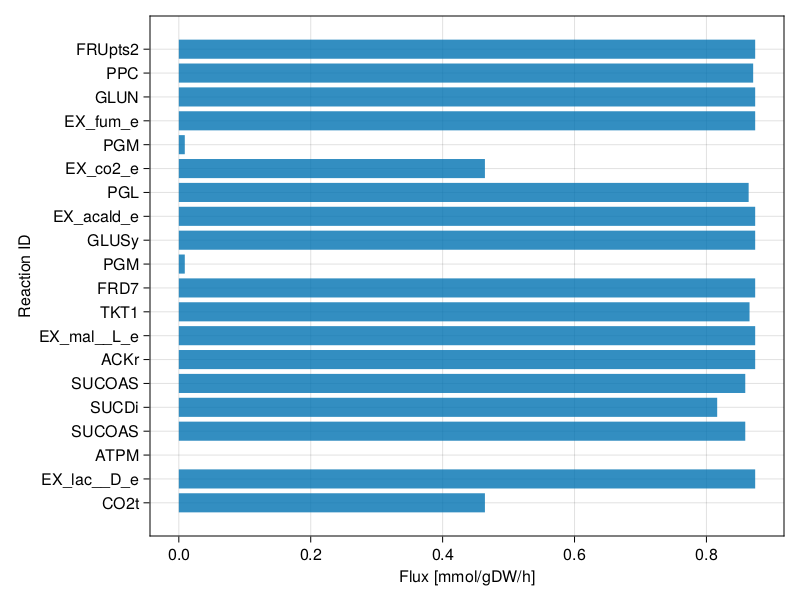

In [4]:
using CairoMakie

disp_rxns = rand(1:95, 20) # only display 20 random fluxes to save space
barplot(
    productions[disp_rxns],
    direction = :x,
    axis = (
        yticks = (1:20, reactions(model)[disp_rxns]),
        xlabel = "Flux [mmol/gDW/h]",
        ylabel = "Reaction ID",
    ),
)

## Knocking out reaction combinations

It is very easy to prepare matrices of biomass productions from all possible
two-reaction knockouts. To make it more interesting, we will restrict one of
the reactions of the pair a bit less, to see more possible outcomes.

We do not process all reactions here to make the notebook rendering
efficient, but you can easily remove the restriction, and speed the process
up using parallel execution, by specifying `workers` argument (see
documentation of `screen` for details)

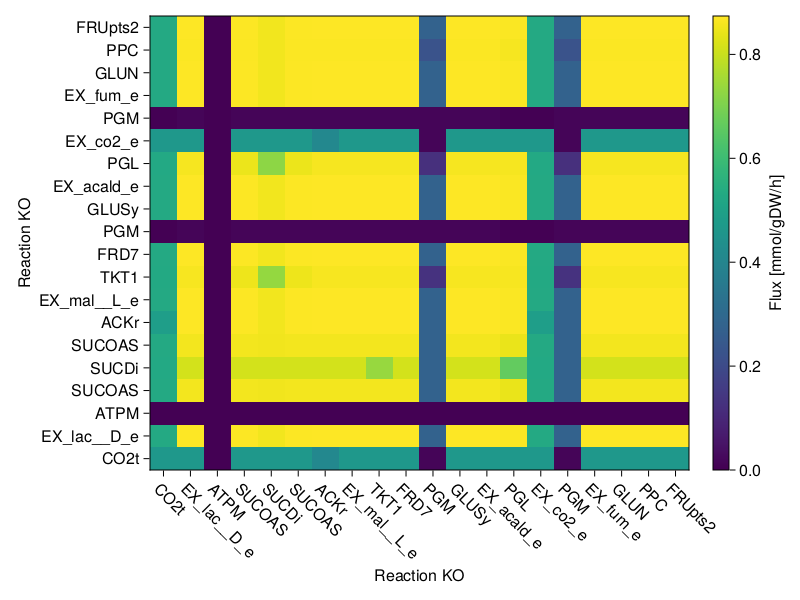

In [5]:
rxns = reactions(model)

productions = screen_variants(
    model,
    [
        [with_limited_rate(rxn1, 3), with_limited_rate(rxn2, 0.1)] for rxn1 in rxns,
        rxn2 in rxns
    ],
    model -> get_biomass(flux_balance_analysis_dict(model, Tulip.Optimizer)),
)

f = Figure()
ax = Axis(
    f[1, 1],
    ylabel = "Reaction KO",
    xlabel = "Reaction KO",
    yticks = (1:20, reactions(model)[disp_rxns]),
    xticks = (1:20, reactions(model)[disp_rxns]),
    xticklabelrotation = -pi / 4,
)
hm = heatmap!(ax, productions[disp_rxns, disp_rxns])
Colorbar(f[1, 2], hm, label = "Flux [mmol/gDW/h]")
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*